In [1]:
from adios2toolspy import SuperCell, Particles, Fields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [6]:
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-12/Harris/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-12/HarrisBigGridTout/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-12/HarrisNICell/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-15/HarrisOriginalParams/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-17/Harris/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_1-21/Harris/'
#root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_2-9/Harris/'
root = '/gpfs/alpine/proj-shared/fus137/johnd/harris-xz-summit_2-17/Harris5/'

In [7]:
def averaging(arr, itr=1):
    x, y = arr.shape
    arr = np.pad(arr, ((1,1), (1,1)))
    temp = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            temp[i,j] = (arr[i,j] + arr[i+1,j] + arr[i-1,j] + arr[i,j+1] + arr[i,j-1] + arr[i-1,j-1] + arr[i-1,j+1] + arr[i+1,j-1] + arr[i+1,j+1])/9
    return temp

def fc_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.empty((h,w))
    if dim == 'x':
        #x case 2D tmp[x] = 0.25*(x[i,j,k] + x[i,j-1,k] + x[i,j,k-1] + x[i,j-1,k-1]) #x case 3D
        tmp[:,1:] = 0.5*(x[:,1:] + x[:,:-1])
    elif dim == 'y':
        tmp[1:,1:] = 0.25*(x[1:,1:] + x[:-1,1:] + x[1:,:-1] + x[:-1,:-1])
    else: #'z'
        tmp[1:,:] = 0.5*(x[1:,:] + x[:-1,:])
    return tmp

def ec_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.empty((h,w))
    if dim == 'x':
        tmp[:,1:] = 0.5*(x[:,1:] + x[:,:-1])
    else: # z
        tmp[1:,:] = 0.5*(x[1:,:] + x[:-1,:])
    return tmp


Loading rho_nc_e from File: pfd.005501.xdmf
Loading jx_nc_e from File: pfd.005501.xdmf
Loading jy_nc_e from File: pfd.005501.xdmf
Loading jz_nc_e from File: pfd.005501.xdmf


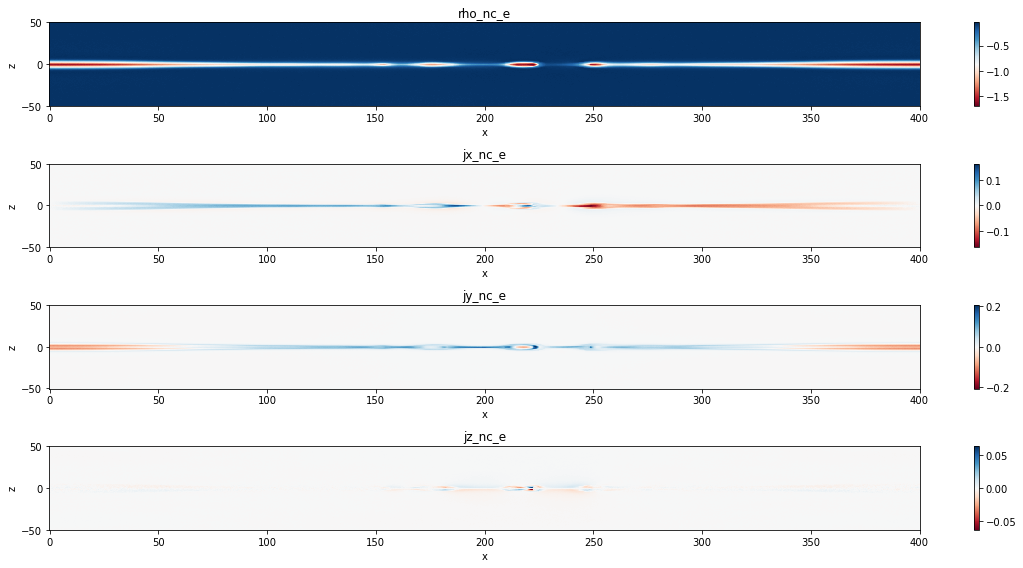

In [8]:
fieldGrid(root, ['rho_nc_e', 'jx_nc_e', 'jy_nc_e', 'jz_nc_e'], [-1], zrange=(None,None), timeAveraged=False)

Loading px_nc_e from File: tfd.001501.xdmf
Loading rho_nc_e from File: tfd.001501.xdmf
Loading ez_ec from File: tfd.001501.xdmf


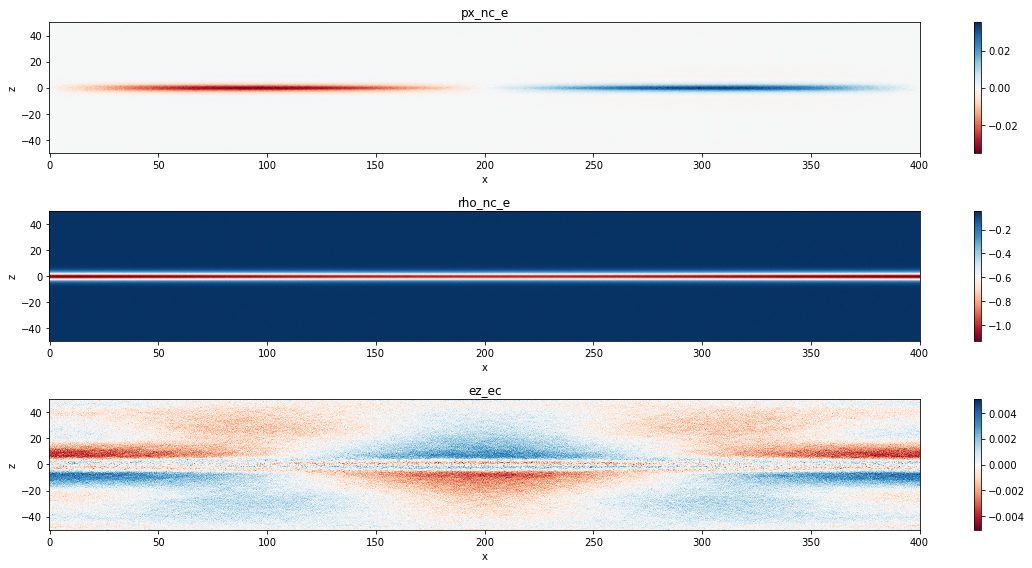

In [9]:
fieldGrid(root, ['px_nc_e', 'rho_nc_e', 'ez_ec'], [31], zrange=(None,None))

Loading jx_nc_e from File: pfd.005501.xdmf
Loading jz_nc_e from File: pfd.005501.xdmf
Loading rho_nc_e from File: pfd.005501.xdmf
Loading rho_nc_e from File: pfd.005500.xdmf


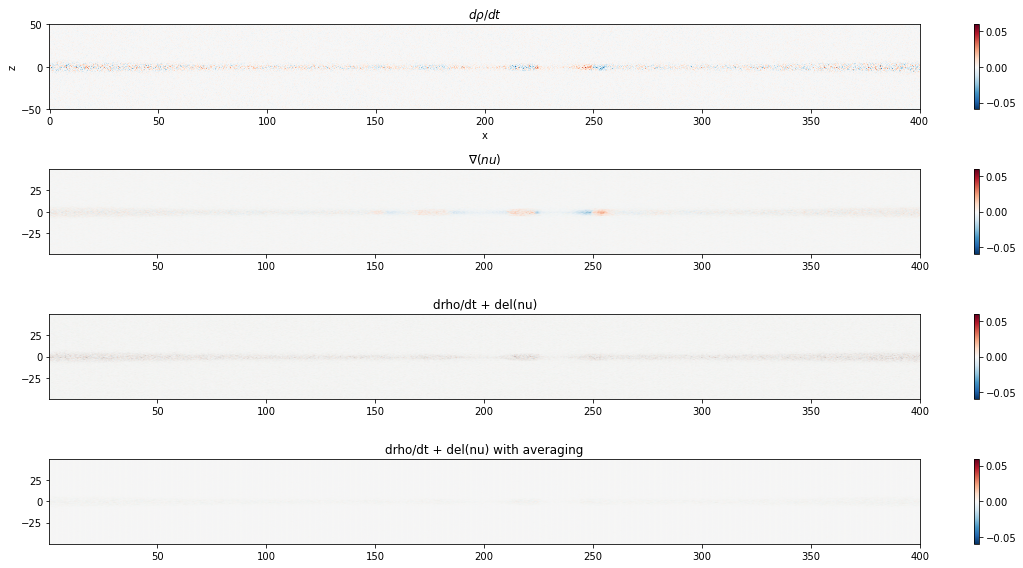

In [10]:
fig, axes = plt.subplots(4,1)
h5p = H5Processor(root, timeAveraged=False)
time = -1
dt = 0.172946 
dx= 0.390625 #dx/de  
dy, dz = 5, 0.195312 # dy/de, dz/de


jx = h5p.getH5Grid('jx_nc_e', time)
jz = h5p.getH5Grid('jz_nc_e', time)


d_jx_dx = (np.diff(jx.data[:,0,:], axis=1, append=0) + np.diff(jx.data[:,0,:], axis=1, prepend=0)) / dx / 2
d_jz_dz = (np.diff(jz.data[:,0,:], axis=0, append=0) + np.diff(jz.data[:,0,:], axis=0, prepend=0)) / dz / 2


del_nu = d_jx_dx + d_jz_dz
del_nu=del_nu[1:,1:]

d_rho_dt = (h5p.getH5Grid('rho_nc_e', time) - h5p.getH5Grid('rho_nc_e', time-1)) / dt

xmax = d_rho_dt.coords['x'].max()
zmax = d_rho_dt.coords['z'].max()
xlin = np.linspace(0, xmax, d_jx_dx.shape[1])[1:]
zlin = np.linspace(-zmax, zmax, d_jx_dx.shape[0])[1:]

d_rho_dt.plot(ax=axes[0])
axes[0].set_title(r'$d\rho/dt$')

pcm1 = axes[1].pcolormesh(xlin, zlin, del_nu, cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm1, ax=axes[1])
axes[1].set_title(r'$\nabla(nu)$')
total = d_rho_dt.data[1:,0,1:] + del_nu

pcm2 = axes[2].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm2, ax=axes[2])
axes[2].set_title('drho/dt + del(nu)')

pcm3 = axes[3].pcolormesh(xlin, zlin, averaging(total), cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm3, ax=axes[3])
axes[3].set_title('drho/dt + del(nu) with averaging')

plt.tight_layout()

Text(0.5, 1.0, 'drho/dt + del(nu) with averaging')

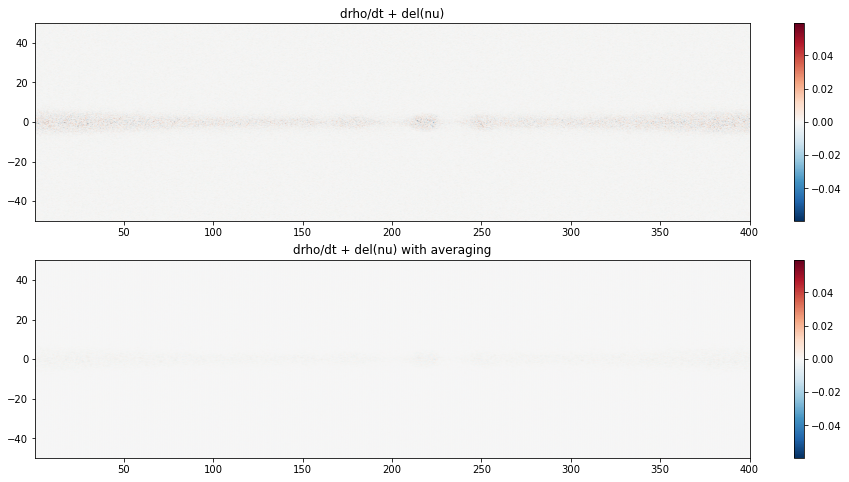

In [11]:
fig, axes = plt.subplots(2,1)

pcm2 = axes[0].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm2, ax=axes[0])
axes[0].set_title('drho/dt + del(nu)')

pcm3 = axes[1].pcolormesh(xlin, zlin, averaging(total), cmap='RdBu_r', shading='gouraud', vmin=-d_rho_dt.max(), vmax=d_rho_dt.max())
fig.colorbar(pcm3, ax=axes[1])
axes[1].set_title('drho/dt + del(nu) with averaging')


In [12]:
ex = h5p.getH5Grid('ex_ec', time).data[:,0,:]
n = h5p.getH5Grid('rho_nc_e', time).data[:,0,:]
jx = h5p.getH5Grid('jx_nc_e', time).data[:,0,:]
jy = h5p.getH5Grid('jy_nc_e', time).data[:,0,:]
jz = h5p.getH5Grid('jz_nc_e', time).data[:,0,:]
by = h5p.getH5Grid('hy_fc', time).data[:,0,:]
bz = h5p.getH5Grid('hz_fc', time).data[:,0,:]
px = h5p.getH5Grid('px_nc_e', time).data[:,0,:]
py = h5p.getH5Grid('py_nc_e', time).data[:,0,:]
pz = h5p.getH5Grid('pz_nc_e', time).data[:,0,:]
ez = h5p.getH5Grid('ez_ec', time).data[:,0,:]
bx = h5p.getH5Grid('hx_fc', time).data[:,0,:]
pxx = h5p.getH5Grid('txx_nc_e', time).data[:,0,:]
pzx = h5p.getH5Grid('tzx_nc_e', time).data[:,0,:]
pxz = h5p.getH5Grid('tzx_nc_e', time).data[:,0,:]
pzz = h5p.getH5Grid('tzz_nc_e', time).data[:,0,:]


Ex = ec_to_nc(ex, dim='x')
Ez = ec_to_nc(ez, dim='z')
Bx = fc_to_nc(bx, dim='x')
By = fc_to_nc(by, dim='y')
Bz = fc_to_nc(bz, dim='z')


Loading ex_ec from File: pfd.005501.xdmf
Loading rho_nc_e from File: pfd.005501.xdmf
Loading jx_nc_e from File: pfd.005501.xdmf
Loading jy_nc_e from File: pfd.005501.xdmf
Loading jz_nc_e from File: pfd.005501.xdmf
Loading hy_fc from File: pfd.005501.xdmf
Loading hz_fc from File: pfd.005501.xdmf
Loading px_nc_e from File: pfd.005501.xdmf
Loading py_nc_e from File: pfd.005501.xdmf
Loading pz_nc_e from File: pfd.005501.xdmf
Loading ez_ec from File: pfd.005501.xdmf
Loading hx_fc from File: pfd.005501.xdmf
Loading txx_nc_e from File: pfd.005501.xdmf
Loading tzx_nc_e from File: pfd.005501.xdmf
Loading tzx_nc_e from File: pfd.005501.xdmf
Loading tzz_nc_e from File: pfd.005501.xdmf


Loading px_nc_e from File: pfd.005500.xdmf


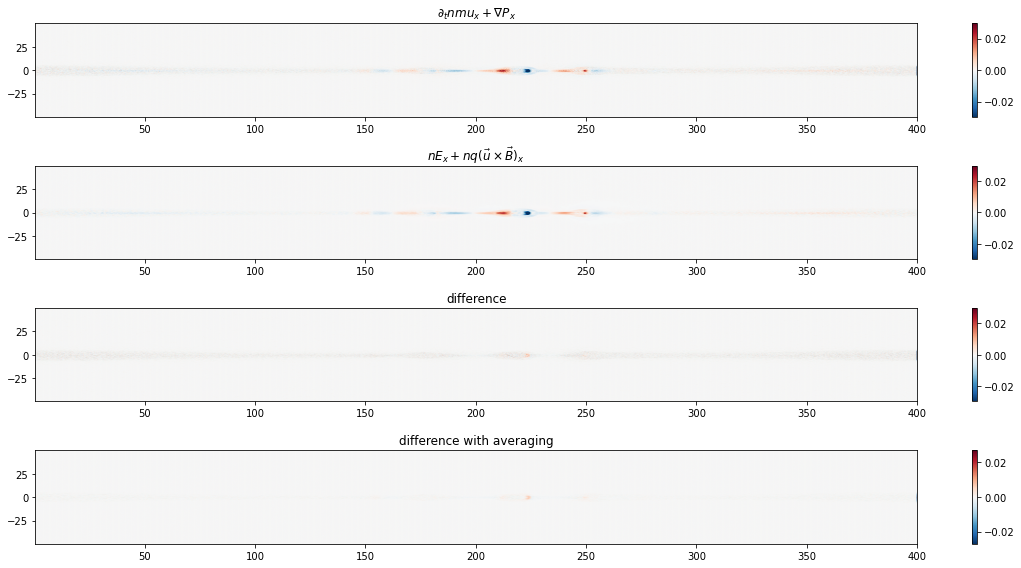

In [13]:
fig, axes = plt.subplots(4,1)

d_px_dt = (px - h5p.getH5Grid('px_nc_e', time-1).data[:,0,:]) / dt

d_px_dt = d_px_dt


d_pxx_dx = (np.diff(pxx, axis=1, prepend=0) + np.diff(pxx, axis=1, append=0)) / dx / 2
d_pzx_dz = (np.diff(pzx, axis=0, prepend=0) + np.diff(pzx, axis=0, append=0)) / dz / 2
div_px = d_pxx_dx + d_pzx_dz

lhs = (d_px_dt + div_px)
lhs = lhs[1:,1:]
rhs = n*Ex + jy*Bz - jz*By
rhs = rhs[1:,1:]

#lhs.plot(ax=axes[0])
pcm = axes[0].pcolormesh(xlin, zlin, lhs, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
axes[0].set_title(r'$\partial_t nmu_x + \nabla P_{x}$')
fig.colorbar(pcm, ax=axes[0])

# #rhs.plot(ax=axes[1])#, vmin=-lhs.max(), vmax=lhs.max(), cmap='RdBu_r')
pcm1 = axes[1].pcolormesh(xlin, zlin, rhs, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
axes[1].set_title(r'$nE_x + nq(\vec{u} \times \vec{B})_x$')
fig.colorbar(pcm1, ax=axes[1])

total = lhs - rhs
pcm2 = axes[2].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm2, ax=axes[2])
axes[2].set_title('difference')
# total.plot(ax=axes[2], vmin=-rhs.max(), vmax=rhs.max(), cmap='RdBu_r')
# axes[2].set_title('difference')

avg = averaging(total)
pcm5 = axes[3].pcolormesh(xlin, zlin, avg, cmap='RdBu_r', shading='gouraud', vmin=-rhs.max(), vmax=rhs.max())
fig.colorbar(pcm5, ax=axes[3])
axes[3].set_title('difference with averaging')
plt.tight_layout()

Loading pz_nc_e from File: pfd.005500.xdmf


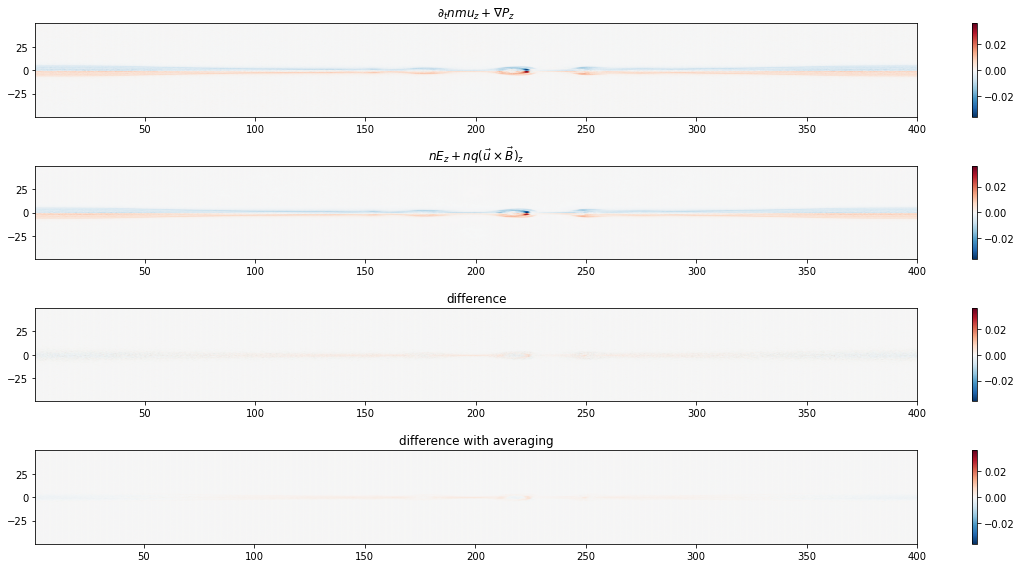

In [14]:
fig, axes = plt.subplots(4,1)

d_pz_dt = (pz - h5p.getH5Grid('pz_nc_e', time-1).data[:,0,:]) / dt
d_pz_dt = d_pz_dt


d_pxz_dx = (np.diff(pxz, axis=1, prepend=0) + np.diff(pxz, axis=1, append=0)) / dx / 2
d_pzz_dz = (np.diff(pzz, axis=0, prepend=0) + np.diff(pzz, axis=0, append=0)) / dz / 2
div_pz = d_pxz_dx + d_pzz_dz

lhs = (d_pz_dt + div_pz)
lhs = lhs[1:,1:]

rhs = n*Ez + jx*By - jy*Bx
rhs = rhs[1:,1:]

pcm = axes[0].pcolormesh(xlin, zlin, lhs, cmap='RdBu_r', shading='gouraud', vmin=-rhs.max(), vmax=rhs.max())
axes[0].set_title(r'$\partial_t nmu_z + \nabla P_{z}$')
fig.colorbar(pcm, ax=axes[0])

pcm1 = axes[1].pcolormesh(xlin, zlin, rhs, cmap='RdBu_r', shading='gouraud', vmin=-rhs.max(), vmax=rhs.max())
axes[1].set_title(r'$nE_z + nq(\vec{u} \times \vec{B})_z$')
fig.colorbar(pcm1, ax=axes[1])

total = lhs - rhs
pcm2 = axes[2].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-rhs.max(), vmax=rhs.max())
fig.colorbar(pcm2, ax=axes[2])
axes[2].set_title('difference')

avg = averaging(total)
pcm5 = axes[3].pcolormesh(xlin[1:], zlin, avg[:,1:], cmap='RdBu_r', shading='gouraud', vmin=-rhs.max(), vmax=rhs.max())
fig.colorbar(pcm5, ax=axes[3])
axes[3].set_title('difference with averaging')
plt.tight_layout()

In [15]:
pxx1 = h5p.getH5Grid('txx_nc_e', time).data[:,0,:]
pxx2 = h5p.getH5Grid('txx_nc_e', time-1).data[:,0,:]
qxxx = h5p.getH5Grid('qxxx_nc_e', time).data[:,0,:]
qxxz = h5p.getH5Grid('qxxz_nc_e', time).data[:,0,:]
pyx = h5p.getH5Grid('txy_nc_e', time).data[:,0,:]
pzx = h5p.getH5Grid('tzx_nc_e', time).data[:,0,:]
pzz1 = h5p.getH5Grid('tzz_nc_e', time).data[:,0,:]
pzz2 = h5p.getH5Grid('tzz_nc_e', time-1).data[:,0,:]
pxz = h5p.getH5Grid('tzx_nc_e', time).data[:,0,:]
pyz = h5p.getH5Grid('tyz_nc_e', time).data[:,0,:]
qzzx = h5p.getH5Grid('qzzx_nc_e', time).data[:,0,:]
qzzz = h5p.getH5Grid('qzzz_nc_e', time).data[:,0,:]


Loading txx_nc_e from File: pfd.005501.xdmf
Loading txx_nc_e from File: pfd.005500.xdmf
Loading qxxx_nc_e from File: pfd.005501.xdmf
Loading qxxz_nc_e from File: pfd.005501.xdmf
Loading txy_nc_e from File: pfd.005501.xdmf
Loading tzx_nc_e from File: pfd.005501.xdmf
Loading tzz_nc_e from File: pfd.005501.xdmf
Loading tzz_nc_e from File: pfd.005500.xdmf
Loading tzx_nc_e from File: pfd.005501.xdmf
Loading tyz_nc_e from File: pfd.005501.xdmf
Loading qzzx_nc_e from File: pfd.005501.xdmf
Loading qzzz_nc_e from File: pfd.005501.xdmf


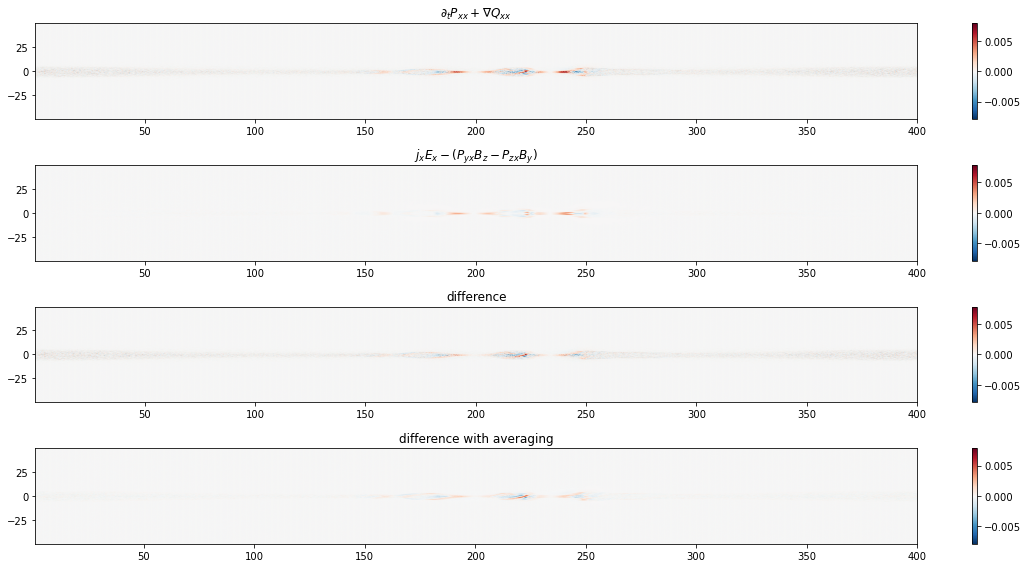

In [16]:
fig, axes = plt.subplots(4,1)


d_pxx_dt = (pxx1 - pxx2)/dt

d_qxxx_dx = (np.diff(qxxx, axis=1, prepend=0)  + np.diff(qxxx, axis=1, append=0)) / dx / 2
d_qxxz_dz = (np.diff(qxxz, axis=0, prepend=0) + np.diff(qxxz, axis=1, append=0)) / dz / 2
div_qxx = d_qxxx_dx + d_qxxz_dz

lhs = d_pxx_dt + div_qxx
lhs = lhs[1:,1:]

rhs = jx * Ex - (pyx * Bz - pzx * By)
rhs = rhs[1:,1:]

pcm = axes[0].pcolormesh(xlin, zlin, lhs, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
axes[0].set_title(r'$\partial_t P_{xx} + \nabla Q_{xx}$')
fig.colorbar(pcm, ax=axes[0])

pcm1 = axes[1].pcolormesh(xlin, zlin, rhs, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
axes[1].set_title(r'$j_x E_x - (P_{yx}B_z - P_{zx}B_y)$')
fig.colorbar(pcm1, ax=axes[1])

total = lhs - rhs
pcm2 = axes[2].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm2, ax=axes[2])
axes[2].set_title('difference')

avg = averaging(total)
pcm5 = axes[3].pcolormesh(xlin[1:], zlin, avg[:,1:], cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm5, ax=axes[3])
axes[3].set_title('difference with averaging')
plt.tight_layout()

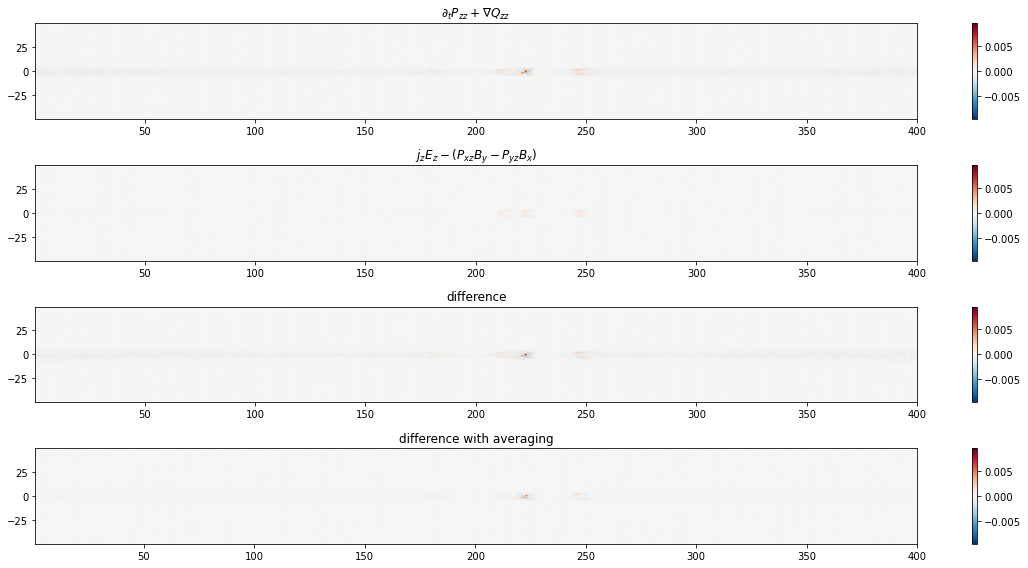

In [17]:
fig, axes = plt.subplots(4,1)

d_pzz_dt = (pzz1 - pzz2)/dt

d_qzzx_dx = (np.diff(qzzx, axis=1, prepend=0)  + np.diff(qzzx, axis=1, append=0)) / dx / 2
d_qzzz_dz = (np.diff(qzzz, axis=0, prepend=0) + np.diff(qzzz, axis=1, append=0)) / dz / 2
div_qzz = d_qzzx_dx + d_qzzz_dz

lhs = d_pzz_dt + div_qzz
lhs = lhs[1:,1:]

rhs = jz * Ez - (pxz * By - pyz * Bx)
rhs = rhs[1:,1:]

pcm = axes[0].pcolormesh(xlin, zlin, lhs, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
axes[0].set_title(r'$\partial_t P_{zz} + \nabla Q_{zz}$')
fig.colorbar(pcm, ax=axes[0])

pcm1 = axes[1].pcolormesh(xlin, zlin, rhs, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
axes[1].set_title(r'$j_z E_z - (P_{xz}B_y - P_{yz}B_x)$')
fig.colorbar(pcm1, ax=axes[1])

total = lhs - rhs
pcm2 = axes[2].pcolormesh(xlin, zlin, total, cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm2, ax=axes[2])
axes[2].set_title('difference')

avg = averaging(total)
pcm5 = axes[3].pcolormesh(xlin[1:], zlin, avg[:,1:], cmap='RdBu_r', shading='gouraud', vmin=-lhs.max(), vmax=lhs.max())
fig.colorbar(pcm5, ax=axes[3])
axes[3].set_title('difference with averaging')
plt.tight_layout()

In [11]:
h5p.attributes

['ex_ec',
 'ey_ec',
 'ez_ec',
 'div_e_err_nc',
 'hx_fc',
 'hy_fc',
 'hz_fc',
 'div_b_err_cc',
 'tcax_ec',
 'tcay_ec',
 'tcaz_ec',
 'rhob_nc',
 'jx_ec',
 'jy_ec',
 'jz_ec',
 'rhof_nc',
 'jx_nc_e',
 'jy_nc_e',
 'jz_nc_e',
 'rho_nc_e',
 'px_nc_e',
 'py_nc_e',
 'pz_nc_e',
 'ke_nc_e',
 'txx_nc_e',
 'tyy_nc_e',
 'tzz_nc_e',
 'tyz_nc_e',
 'tzx_nc_e',
 'txy_nc_e',
 'qxxx_nc_e',
 'qyyy_nc_e',
 'qzzz_nc_e',
 'qxxy_nc_e',
 'qyyz_nc_e',
 'qzzx_nc_e',
 'qxxz_nc_e',
 'qyyx_nc_e',
 'qzzy_nc_e',
 'qxyz_nc_e',
 'jx_nc_i',
 'jy_nc_i',
 'jz_nc_i',
 'rho_nc_i',
 'px_nc_i',
 'py_nc_i',
 'pz_nc_i',
 'ke_nc_i',
 'txx_nc_i',
 'tyy_nc_i',
 'tzz_nc_i',
 'tyz_nc_i',
 'tzx_nc_i',
 'txy_nc_i',
 'qxxx_nc_i',
 'qyyy_nc_i',
 'qzzz_nc_i',
 'qxxy_nc_i',
 'qyyz_nc_i',
 'qzzx_nc_i',
 'qxxz_nc_i',
 'qyyx_nc_i',
 'qzzy_nc_i',
 'qxyz_nc_i']

Loading rho_nc_e from File: pfd.005700.xdmf
Loading rho_nc_e from File: pfd.005600.xdmf


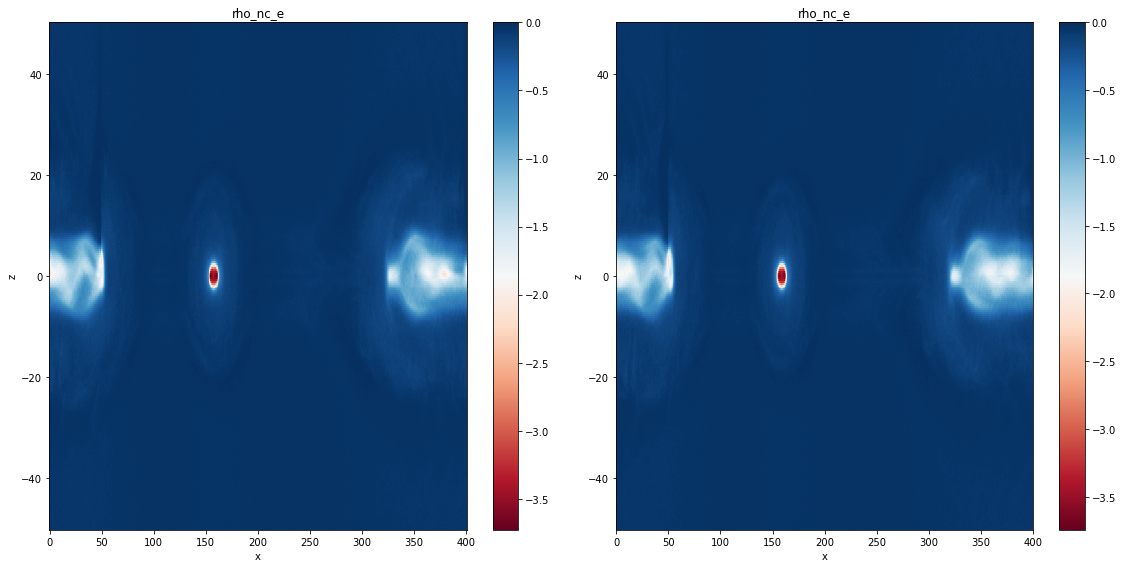

In [17]:
fieldGrid(root, ['rho_nc_e'], [-1,-2], zrange=(None,None), timeAveraged=False)